In [1]:
from tensorflow.keras.layers import Bidirectional, GRU, LSTM

144
104
Epoch 1/100
25/25 [==============================] - 11s 29ms/step - loss: 0.2704 - mae: 0.4381 - lr: 1.0000e-08
Epoch 2/100
25/25 [==============================] - 0s 14ms/step - loss: 0.2692 - mae: 0.4369 - lr: 1.1220e-08
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 0.2679 - mae: 0.4356 - lr: 1.2589e-08
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 0.2664 - mae: 0.4341 - lr: 1.4125e-08
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 0.2648 - mae: 0.4325 - lr: 1.5849e-08
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 0.2630 - mae: 0.4308 - lr: 1.7783e-08
Epoch 7/100
25/25 [==============================] - 0s 15ms/step - loss: 0.2610 - mae: 0.4288 - lr: 1.9953e-08
Epoch 8/100
25/25 [==============================] - 0s 15ms/step - loss: 0.2588 - mae: 0.4266 - lr: 2.2387e-08
Epoch 9/100
25/25 [==============================] - 0s 15ms/step - loss: 0.2564 - mae: 0.4242 

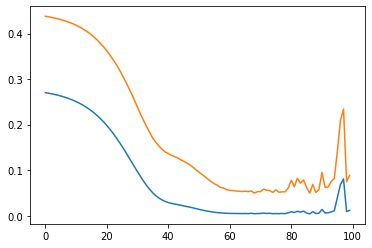

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
def get_data():
    df=pd.read_csv("/content/monthly-airline-passengers.csv")
    return df.Month.values, df.Passengers.values
def preprocess(x):
    x=scaler.fit_transform(x.reshape([-1,1]))
    return x
def windowed_dataset(series, windowsi, batch_si, shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(windowsi+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window:window.batch(windowsi+1))
    dataset=dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1],window[-1]))
    dataset=dataset.batch(batch_si).prefetch(1)
    return dataset
months,data=get_data()
data=preprocess(data)
print(len(data))
split_time=104
time=range(len(data))
x_train=data[:split_time]
print(len(x_train))
x_test=data[split_time:]
time_train=time[:split_time]
time_valid=time[split_time:]
# data=tf.data.Dataset.range(144)
batchsi=4
windowsi=5
dataset=windowed_dataset(x_train,windowsi,batchsi,int(len(data)*0.3))
def build_model(dataset,batchsi, windowsi):
    model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
      ])
    return model
scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 *10**(epoch/20))
callback=tf.keras.callbacks.EarlyStopping(patience=4, monitor='loss')
model=build_model(dataset,batchsi,windowsi)
model.compile(loss="mse",optimizer="adam",metrics="mae")
history=model.fit(dataset,epochs=100, callbacks=[scheduler])
# history=model.fit(dataset,epochs=400)
def plot_loss(history):
    plt.semilogx(history.history['lr'],history.history["loss"])
    plt.axis([1e-8,1e-3, 0,0.1   ])
    plt.show()
# plot_loss(history)
def plot_loss_mae(history):
    epoch=range(len(history.history["loss"]))
    loss=history.history["loss"]
    mae=history.history["mae"]
    plt.plot(epoch,loss)
    plt.plot(epoch,mae)
    plt.show()
plot_loss_mae(history)

In [ ]:
model.save('MonthlyAirlinePassengers.h5')